# Digital FIR Filter Design. 
## Task. 
Download a sample track. The recording contains a recording that has a high-frequency noise around 5kHz, as well as low-frequency noise at 200Hz.
1. Design an FIR filter that will filter high-frequency noise (low-pass filter). You need to construct ideal frequency response (use code from examples), compute IRC in time domain
using ifft, shift the IRC using ifftshift, apply a window function (for example kaiser). Use around 200-300 samples for this filter.
2. Design an FIR filter that will filter low-frequency noise (high-pass filter). You need to construct ideal frequency response (modify code from examples), compute IRC in time domain using ifft , shift the IRC using ifftshift , apply a window function (for example kaiser ). The more samples you use, the better the filtration quality (try around 1000 samples).
3. Apply both of the filters to the original recording to obtain clearer audio. 

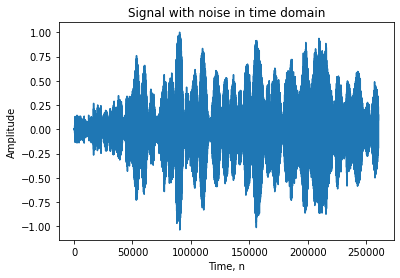

In [1]:
import numpy as np
from math import floor
from scipy.fftpack import fft,ifft, ifftshift
from scipy.signal.windows import kaiser 
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio

# Initial signal with noise
signal_rate, signal = wavfile.read('signal_with_noise.wav')

# Plotting the signal 
plt.plot(signal)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Signal with noise in time domain")

# Generate audio
Audio(signal,rate=signal_rate)

Text(0.5, 1.0, 'Signal with noise in frequency domain')

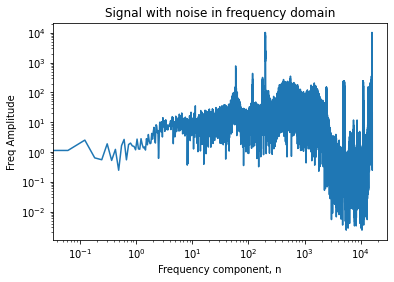

In [2]:
# Plot spectrum
# Calculate frequencies
s_len = len(signal)
frequencies = np.arange(0,(s_len))/(s_len) * signal_rate;
# Plot
plt.semilogy(frequencies, abs(fft(signal)))
plt.xscale("log")
plt.xlabel("Frequency component, n")
plt.ylabel("Freq Amplitude")
plt.title("Signal with noise in frequency domain")

**The algorithm of constructing the FIR filter:**
1. Specify the desired frequency response
2. Compute impulse response in the temporal domain
3. Apply a window function
4. Evaluate the result

**So, both the lowpass and the highpass filters were constructed according to this algorithm.**

The lowpass filter allows only low-frequency components to pass through. The filter is defined with a series of coefficients $(h_{low})_n$, where $n=1..N$. 
The highpass filter allows only high-frequency components to pass through. The filter is defined with a series of coefficients $(h_{high})_n$, where $n=1..N$. 

**The main thing to achieve the removal of the noise was to decide upon `cutoff` value for the both filters. This variable defines which ratio of frequencies from the initial signal will be preserved.**

For the lowpass filter, I've chosen `cutoff=0.1875`, because, in the recording, human speech is at frequencies below 3kHz, meaning that we can cut off frequencies from $\frac{3}{16}=0.1875$ kHz. 
For the highpass filter I've chosen `cutoff=0.02`, because, even though, the task described the noise around 200Hz, which gives `cutoff=`$\frac{0.2}{16}=0.0125$ kHz, that value wasn't sufficient to remove all low-frequency noise. 

Text(0.5, 1.0, 'Frequency response of ideal low-pass filter')

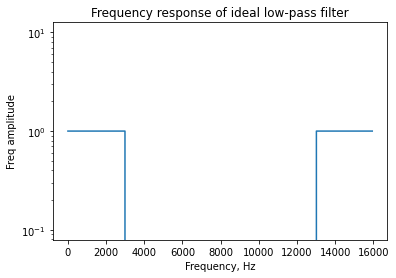

In [3]:
def ideal_lowpass(N, cutoff, stop_value):
  """
  N: integer length of FIR filter
  cutoff: fraction of Fs, at which frequencies are stopped
  stop_value: the value for frequencies in the stopband
  (after cutoff frequency)
  return: frequency representation of an ideal
  low pass FIR filter of length N+1 if N is even
  or N if N is odd
  """
  N = int((N - N % 2) / 2)
  cutoff = int(floor(2 * N * cutoff))
  H = np.ones((N,)) * stop_value
  H[:cutoff] = 1.
  H = np.concatenate([np.ones((1,)), H, np.flip(H)])
  return H


# Calculate lowpass filter with length 257
H_l = ideal_lowpass(256, 0.1875, 0.)
# Calculate frequencies
h_len = len(H_l)
frequencies_l = np.arange(0,h_len)/h_len * signal_rate

# Plot
plt.plot(frequencies_l, H_l)
plt.yscale("log")
plt.xlabel("Frequency, Hz")
plt.ylabel("Freq amplitude")
plt.title("Frequency response of ideal low-pass filter")

Text(0.5, 1.0, 'Impulse response of ideal low-pass filter')

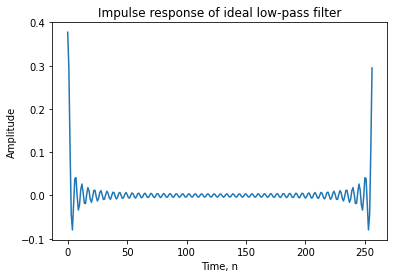

In [4]:
# Compute impulse response projected into temporal domain
h_l = np.real(ifft(H_l))
plt.plot(np.arange(0,len(h_l)), h_l)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal low-pass filter")

For now, the lowpass filter is zero-phase filter, and it is not causal. To solve this issue, I need to introduce a linear phase to the frequency response.

Text(0.5, 1.0, 'Impulse response of ideal low-pass filter')

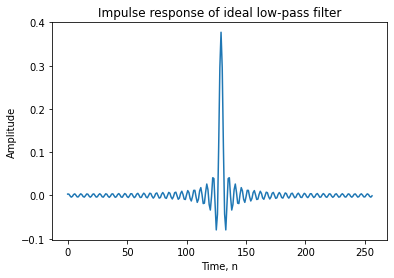

In [5]:
# Introduce a linear phase
h_l_shifted = ifftshift(h_l)
plt.plot(np.arange(0,len(h_l_shifted)), h_l_shifted)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal low-pass filter")

Text(0.5, 1.0, 'Impulse response of ideal low-pass filter')

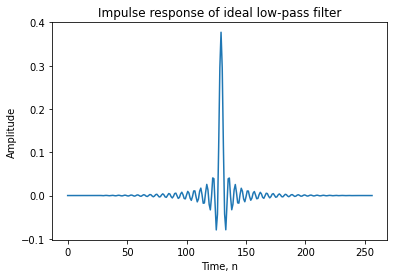

In [6]:
# Applying the Window Function - kaiser
h_l_shifted = h_l_shifted * kaiser(len(h_l_shifted), 8)
plt.plot(np.arange(0,len(h_l_shifted)), h_l_shifted)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal low-pass filter")

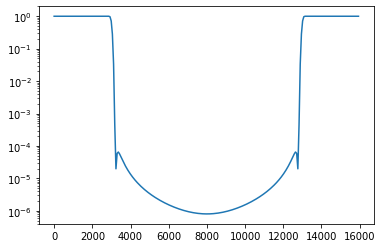

In [7]:
# Evaluating the result
plt.semilogy(frequencies_l, abs(fft(h_l_shifted)))

The quality of the filter is further decided by how well it can suppress frequencies in the stopband. If the result is not satisfactory, one can try other windows or initial frequency response, implement a longer FIR filter or another filter's design.

**The same steps to construct a highpass filter.**

Text(0.5, 1.0, 'Frequency response of ideal highpass filter')

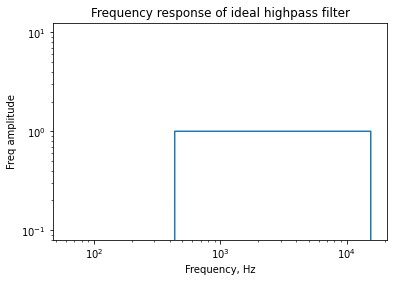

In [8]:
def ideal_highpass(N, cutoff, stop_value):
  """
  N: integer length of FIR filter
  cutoff: fraction of Fs, at which frequencies are stopped
  stop_value: the value for frequencies in the stopband
  (after cutoff frequency)
  return: frequency representation of an ideal
  high pass FIR filter of length N+1 if N is even
  or N if N is odd
  """
  N = int((N - N % 2) / 2)
  cutoff = int(floor(2 * N * cutoff))
  H = np.ones((N,)) * stop_value # zeros only
  H[cutoff:] = 1.
  H = np.concatenate([H, np.ones((1,)), np.flip(H)])
  return H


# Calculate highpass filter with length 257
H_h = ideal_highpass(256, 0.03, 0.)
# Calculate frequencies
frequencies_h = np.arange(0,len(H_h))/len(H_h) * signal_rate

# Plot
plt.plot(frequencies_h, H_h)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency, Hz")
plt.ylabel("Freq amplitude")
plt.title("Frequency response of ideal highpass filter")

Text(0.5, 1.0, 'Impulse response of ideal highpass filter')

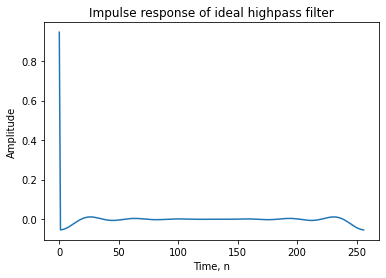

In [9]:
# Compute impulse response projected into temporal domain
# imaginary part should be close to 0
h_h = np.real(ifft(H_h))
plt.plot(np.arange(0,len(h_h)), h_h)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal highpass filter")

Text(0.5, 1.0, 'Impulse response of ideal highpass filter')

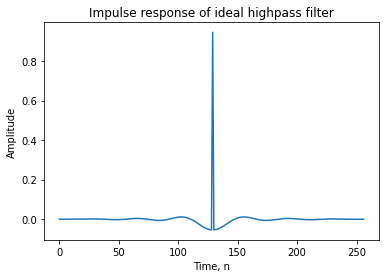

In [10]:
# Introduce a linear phase
h_h_shifted = ifftshift(h_h)
plt.plot(np.arange(0,len(h_h_shifted)), h_h_shifted)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal highpass filter")

Text(0.5, 1.0, 'Impulse response of ideal highpass filter')

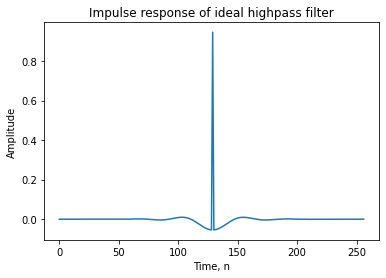

In [11]:
# Applying the Window Function - kaiser
h_h_shifted = h_h_shifted * kaiser(len(h_h_shifted), 8)
plt.plot(np.arange(0,len(h_h_shifted)), h_h_shifted)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal highpass filter")

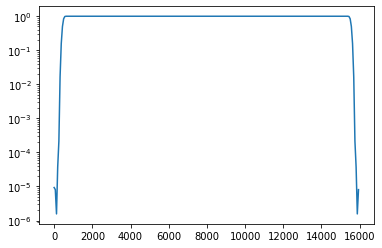

In [12]:
# Evaluating the result
plt.semilogy(frequencies_h, abs(fft(h_h_shifted)))

One can apply the filter simply by performing the convolution between the signal and the designed filter response. The spectrogram investigation shows that the filter works as expected.

In [13]:
def FIR_filter(signal, filter):
  return np.convolve(signal, filter) 

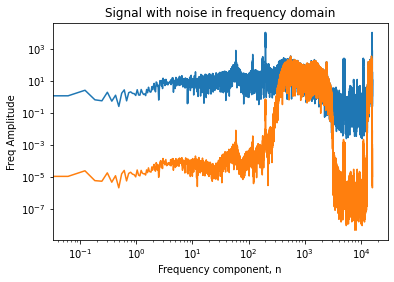

In [14]:
# Apply both of the filters to the original recording. 
signal_filtered = FIR_filter(signal, h_l_shifted)
signal_filtered = FIR_filter(signal_filtered, h_h_shifted)
frequencies_filtered = np.arange(0,len(signal_filtered))/len(signal_filtered) * signal_rate

# Plot
plt.semilogy(frequencies, abs(fft(signal)))
plt.semilogy(frequencies_filtered, abs(fft(signal_filtered)))
plt.xscale("log")
plt.xlabel("Frequency component, n")
plt.ylabel("Freq Amplitude")
plt.title("Signal with noise in frequency domain")

# generate audio
Audio(signal_filtered,rate=signal_rate)

## Self-check Questions:
- *What is a Hermitian function?*
It is a function $f$ with the property:
$f^{*}(x)=f(-x)$

It can be used to perform the discrete Fourier transform of a real signal and efficiently store the transformed signal in the same space as the original real signal.

- *What are the criteria for the designed filter to have only real values?*

For any real filter, the constant phase can be either 0 or $ \pi $.

- *Why does one need to introduce a linear-phase shift?*

When the filter has phase equal to 0, the frequency response of the filter has only the real part. Such filters are called zero-phase filters, and in general, they are not causal. So, we introduce a linear-phase shift to solve this issue. Causal filtering is usually computationally more efficient. In addition, causal filters are be used for real-time applications since the entire signal is available and fast reaction to the current input is required. 

- *What is the difference between various window functions? Why does one need to apply a window function?*

In the digital signal processing the window function is used to remove noise from the signal, and to perform signal estimation and signal analysis. 

Different window functions are needed for different goals: a more precise amplitude, a lower noise floor, different ranges of frequencies. 

- *What is the spectrum equivalent to applying a window function?*

As the input signal for DFT is finite and may have discontinuity points repeatedly, thus we need window finctions to eliminate consequences of discontinuity in the spectrum. The window function, the shape of the window define what type of distortions are introduced in the spectrum.
